### Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
df = pd.read_csv('../Data/combined_data.csv')
df = df[df['speed'] == 1]  
df = df[df['node-id'] == 562]
df = df.reset_index(drop=True)

In [3]:
num_classes = 3 # Change the number of classes here
df['weight_class'] = pd.qcut(df['weight'], q=num_classes, labels=False)
df

,speed,weight,node-id,timestamp,ax,ay,az,gx,gy,gz,weight_class
0,1,85.1,562,1556.515,-0.651223,-10.10830,0.663194,-3.479000,-0.244141,3.814700,0
1,1,85.1,562,1556.520,-0.359130,-10.26150,1.213860,-3.570560,-1.739500,4.089360,0
2,1,85.1,562,1556.525,0.605733,-10.18250,0.816423,-3.112790,-3.387450,4.211430,0
3,1,85.1,562,1556.530,0.004788,-8.87531,2.176330,-1.220700,-4.272460,4.180910,0
4,1,85.1,562,1556.535,-0.119710,-9.30866,4.273650,0.762939,-5.401610,4.150390,0
...,...,...,...,...,...,...,...,...,...,...,...
959995,1,104.5,562,2331.330,1.592140,-9.28711,2.097320,1.190190,0.396729,-0.274658,2
959996,1,104.5,562,2331.335,1.608900,-9.29190,2.118870,1.190190,0.457764,-0.213623,2
959997,1,104.5,562,2331.340,1.644820,-9.28232,2.135630,1.342770,0.427246,-0.061035,2
959998,1,104.5,562,2331.345,1.625660,-9.25838,2.130840,1.312260,0.457764,0.030518,2


In [4]:
# Group the DataFrame by 'weight_class' and get unique 'weight' in each group
weights_by_class= df.groupby('weight_class')['weight'].unique()

# Sort the weights in each class
weights_by_class= weights_by_class.apply(lambda x: sorted(list(x)))

weights_by_class

weight_class
0    [85.1, 86.7, 88.35, 89.4, 90.6, 91.95]
1           [93.35, 94.5, 95.0, 96.1, 97.6]
2       [98.85, 100.0, 101.6, 103.0, 104.5]
Name: weight, dtype: object

In [5]:
def train_test_split(df):
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()

    for weight_class, weights in weights_by_class.items():
        test_indices = [1, 3] # Select the test indices
        test_weights = [weights[i] for i in test_indices]
        train_weights = [weight for i, weight in enumerate(weights) if i not in test_indices]

        df_train = pd.concat([df_train, df[df['weight'].isin(train_weights) & (df['weight_class'] == weight_class)]],
                             ignore_index=True)
        df_test = pd.concat([df_test, df[df['weight'].isin(test_weights) & (df['weight_class'] == weight_class)]],
                            ignore_index=True)

    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    return df_train, df_test

In [6]:
df_train, df_test = train_test_split(df)

In [7]:
n_features = 6
def get_segments(df, segment_size, step_size):
    segments = []
    labels = []
    
    for i in range(0, df.shape[0] - segment_size, step_size):
        axs = df['ax'].values[i: i + segment_size]
        ays = df['ay'].values[i: i + segment_size]
        azs = df['az'].values[i: i + segment_size]
        gxs = df['gx'].values[i: i + segment_size]
        gys = df['gy'].values[i: i + segment_size]
        gzs = df['gz'].values[i: i + segment_size]

        label = df['weight_class'].iloc[i: i + segment_size].mode()[0]
        
        segments.append([axs, ays, azs, gxs, gys, gzs]) 
        labels.append(label)
    
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, segment_size * n_features) # MLP expects 2D input
    labels = np.asarray(labels).reshape(-1, 1)
    
    return reshaped_segments, labels

In [8]:
segment_size = 400
step_size = 100
X_train, y_train = get_segments(df_train, segment_size, step_size)
X_test, y_test = get_segments(df_test, segment_size, step_size)
print(X_train.shape, y_train.shape)

(5996, 2400) (5996, 1)


In [9]:
# Standardize the data  
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [10]:
# Train MLP model
# mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=42) 
# mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42) 
# mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42, activation='relu', solver='lbfgs') # lbgfs solver seems better
mlp.fit(X_train, y_train.ravel())

MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42,
              solver='lbfgs')


 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1199
           1       0.60      0.69      0.64      1200
           2       0.84      0.65      0.73      1197

    accuracy                           0.73      3596
   macro avg       0.75      0.73      0.74      3596
weighted avg       0.75      0.73      0.73      3596



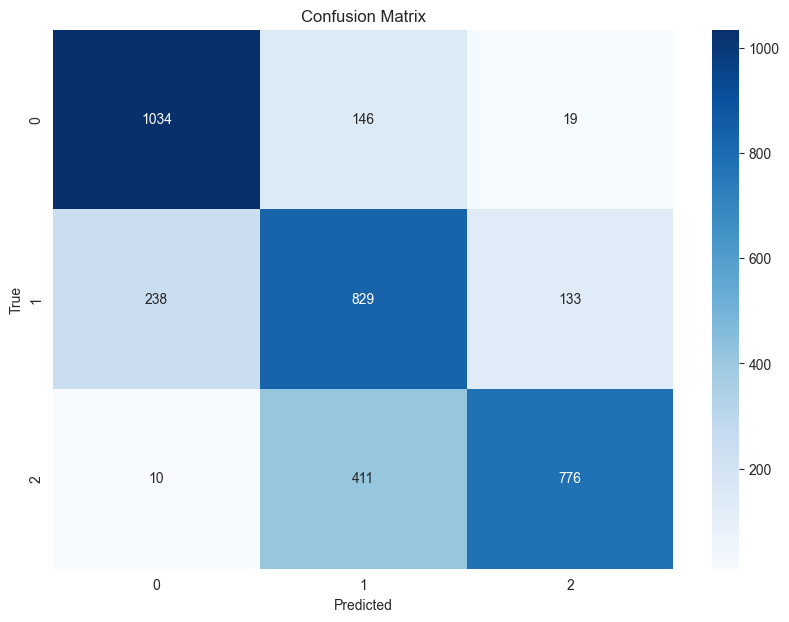

In [11]:
res_dir = 'Results/MLP/Weight_Classes/{0}_classes/'.format(num_classes)
# Predict and evaluate the model
y_pred = mlp.predict(X_test)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("\n -------------Classification Report-------------\n")
print(report)

# with open(res_dir + 'MLP_classification_report.txt', 'w') as f:
#     f.write(report)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
# plt.savefig(res_dir + 'MLP_confusion_matrix.png')
plt.show()